Here we will try to do some creation of a vector field from the brushstrokes generated in the last image.

Firstly we want to expand each brushstroke so that they fill the frame. We can do this with a morphological transform. We will follow a fairly basic process:
1. Fill a frame with ones, call this A
2. Iterate over each brushstroke, growing it slightly
3. Elementwise multiply it by the matrix A.
4. Subtract this from A. Over time A will represent the area which is not assigned to a brushtroke.

In [29]:
import cv2
import scipy.stats.qmc as qmc
import scipy
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from collections import Counter
import random

random.seed(1)

In [30]:
with open('../out/m_test.pkl', 'rb') as inp:
    gradients = pickle.load(inp)
with open('../out/strokes_test.pkl', 'rb') as inp:
    brushstrokes = pickle.load(inp)
sz = np.shape(brushstrokes[0])
numbrush = len(brushstrokes)
thetas = np.arctan(gradients)
im = cv2.imread('../res/test.jpeg')

im = cv2.resize(im, (np.int16(np.shape(im)[1]/4),np.int16(np.shape(im)[0]/4)))
im = cv2.colorChange(im, None, cv2.COLOR_RGB2BGR)

In [31]:
kernel = np.ones([3,3], np.uint8)
brushstrokes_dilated = brushstrokes.copy()
indices = list(range(numbrush))
A = np.ones(sz, np.uint8)
# First pass - remove current brushstrokes from A
for i in range(numbrush):
    A = A-brushstrokes[i]

while len(indices) > 0:
    for i in range(len(indices)-1,-1,-1):
        
        idx = indices[i]
        dilated = cv2.dilate(np.uint8(brushstrokes_dilated[idx]), kernel)
        check_idx = 65
        # if (idx==check_idx):

            # plt.subplot(1,4,1)
            # plt.imshow(dilated)
        dilated = dilated * A + brushstrokes_dilated[idx]
        # if (idx==check_idx):
            # plt.subplot(1,4,2)
            # plt.imshow(dilated)
        if (np.sum(dilated) == np.sum(brushstrokes_dilated[idx])):
            indices.pop(i)
            break
        else:
            brushstrokes_dilated[idx] = dilated
            A = A - dilated*A
        # if (idx==check_idx):
            # print("C",np.sum(brushstrokes[idx]),",", np.sum(brushstrokes_dilated[idx]))
            # plt.subplot(1,4,3)
            # plt.imshow(brushstrokes_dilated[idx])
            # plt.subplot(1,4,4)
            # plt.imshow(A)
            # plt.show()


Next we want to identify every brushstroke's three nearest neighbours. We can do this by dilating each brushstroke by one pixel, multiplying a matrix containing each brushstroke's index by this dilated pixel, and identifying each item in that appears in that matrix.

In [32]:
vector_of_xmeans = np.zeros([1,numbrush])
vector_of_ymeans = np.zeros([1,numbrush])
a = np.ones([sz[0],1])
b = np.array([range(sz[1])])
x_ordinates = a @ b

a = np.array([range(sz[0])]).T
b = np.ones([1,sz[1]])
y_ordinates =  a @ b
for i in range(numbrush):
    # plt.imshow(brushstrokes[i])
    # plt.show()
    x_ords_brush = np.bool8(brushstrokes[i])
    x_ords_brush = np.float16(x_ordinates[x_ords_brush])
    x_mean = np.mean(x_ords_brush)
    vector_of_xmeans[0,i] = x_mean

    y_ords_brush = np.bool8(brushstrokes[i])
    y_ords_brush = np.float16(y_ordinates[y_ords_brush])
    y_mean = np.mean(y_ords_brush)
    vector_of_ymeans[0,i] = y_mean

mean_locations = np.hstack((vector_of_xmeans.T, vector_of_ymeans.T))

In [33]:
# def get_polarity_probability(region_index, polarities):
#     probability = 0
#     # indxes = np.array([neighbour_1[region_index], neighbour_2[region_index], neighbour_3[region_index]], np.int64)
#     # indxes = neighbours[region_index,:]
#     indxes = np.argsort(matrix_of_dist[region_index])[1:k+1]
#     for idx in indxes:
#         if ((idx != -1) and (polarities[idx] != 0)):
#             dtheta = (thetas[region_index]-thetas[idx]+np.pi/2)%np.pi-np.pi/2
#             p = np.cos(dtheta)
#             sign_applied = 1
#             mean_theta_abs = (abs(thetas[region_index])+abs(thetas[idx]))/2
#             if mean_theta_abs < np.pi / 4:
#                 sign_applied = np.sign(thetas[region_index]) * np.sign(thetas[idx])
#             if (np.abs(probability) ==0):
#                 probability = p * polarities[idx]*sign_applied
#     return probability

def get_probability_vector(polarities, matrix_of_dist_sq, gradients):
    numbrush = np.size(gradients)
    thetas = np.arctan(gradients)
    theta_mat = np.ones([numbrush,1])@np.array([thetas])
    dtheta_mat = (theta_mat-theta_mat.T+np.pi/2)%np.pi-np.pi/2
    angle_factor = np.cos(dtheta_mat)
    mean_theta_abs = (np.abs(theta_mat)+np.abs(theta_mat.T))/2
    mask_sign = np.bool8(mean_theta_abs < np.pi/4)
    sign_matrix = np.zeros([numbrush,numbrush])
    sign_matrix[mask_sign] = (np.sign(theta_mat)*np.sign(theta_mat.T))[mask_sign]
    sign_matrix[np.bool8(1-mask_sign)] = 1
    polarities_factor = np.ones([numbrush,1])@np.array([polarities])
    matrix_of_dist_sq_zero_diag = matrix_of_dist_sq
    matrix_of_dist_sq_zero_diag[np.bool8(np.eye(numbrush, numbrush))] = np.inf
    probability_matrix = angle_factor * sign_matrix / matrix_of_dist_sq_zero_diag *polarities_factor
    probability_vector = np.sum(probability_matrix, axis = 1)
    mask_already_assigned = np.bool8(polarities!=0)
    probability_vector[mask_already_assigned] = 0
    return (probability_vector)

        

In [34]:
def get_matrix_of_dist_sq(mean_locations):
    numbrush = np.size(mean_locations,0)
    matrix_of_xmeans = np.ones([numbrush,1]) @ np.array([mean_locations[:,0]])
    matrix_of_ymeans = np.ones([numbrush,1]) @ np.array([mean_locations[:,1]])

    matrix_of_xdist = matrix_of_xmeans - matrix_of_xmeans.T
    matrix_of_ydist = matrix_of_ymeans - matrix_of_ymeans.T
    matrix_of_dist_sq = matrix_of_xdist * matrix_of_xdist + matrix_of_ydist * matrix_of_ydist
    # matrix_of_dist = np.sqrt(matrix_of_dist_sq)
    return matrix_of_dist_sq

In [35]:

def get_polarity_option(mean_locations, gradients):
    matrix_of_dist_sq = get_matrix_of_dist_sq(mean_locations)
    numbrush = np.size(gradients)
    polarities = np.zeros([numbrush])
    #1: randomly assign n polarities
    for i in range(1):
        ran_brush = random.randint(0,numbrush-1)
        polarities[ran_brush] = np.sign(random.random()-0.5)
    while 0 in polarities:
        probabilities = get_probability_vector(polarities, matrix_of_dist_sq, gradients)
        
        index_to_change = np.argmax(np.abs(probabilities))
        polarities[index_to_change] = np.sign(probabilities[index_to_change])
        
    return polarities


In [36]:
polarity_option = get_polarity_option(mean_locations, gradients)

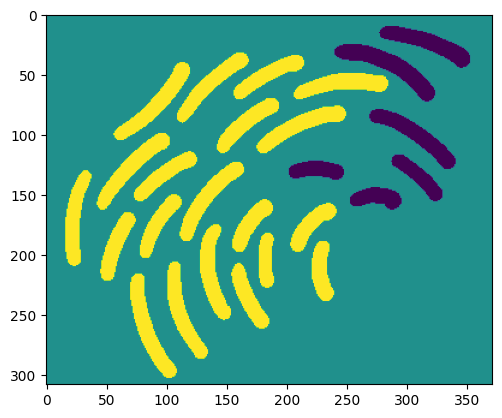

In [37]:
brush_directions = np.zeros(sz)+0.5
for i in range(numbrush):
    brush_directions += brushstrokes[i]*(polarity_option[i])/2
plt.imshow(brush_directions)

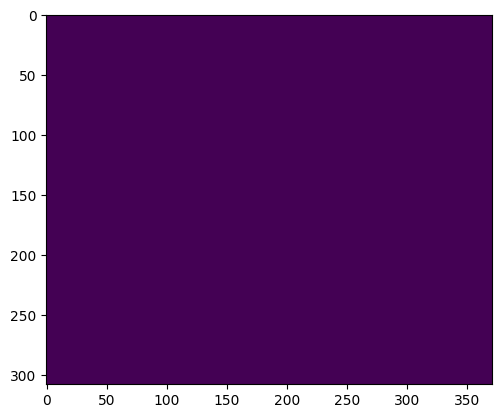

In [38]:
##HYPERPARAMETER
num_polarity_options = 20

opts = np.zeros([num_polarity_options, numbrush])
for i in range(10):
    opt_valid = False
    while opt_valid == False:
        opt = get_polarity_option(mean_locations, gradients)
        opt_valid = opt[0]
        opt = opt[1]
    if (i!=0):
        running_best = np.mean(opts, axis=0)
        diff_pos = running_best - opt
        diff_neg = running_best + opt
        if (np.abs(np.sum(diff_neg)) < np.abs(np.sum(diff_pos))):
            opt *= -1
    opts[i,:] = opt

    
brush_directions = np.zeros(sz)
best_polarity = np.sign(np.mean(opts, axis = 0))
# best_polarity = np.sign(np.random.random(np.size(best_polarity))-0.5)
for i in range(numbrush):
    brush_directions += brushstrokes_dilated[i]*(best_polarity[i])/2

plt.imshow(brush_directions)

# Promising?

[0.494421509586466, 2.8128216475856633, -1.0438634926921218, 0.6564967960724846, -1.0346440414731999, 0.3477156606552684, -0.44112374319314784, 7.341217867561108, -1.284513712570038, 3.063212433494036, -0.10429176699236645, -0.9514361229514949, -7.988509067570571, -0.8252649058806691, -0.5319969584193116, -0.7232626501970222, -2.5921615947765715, 2.112924998445444, -1.6993180952922518, -1.0785844806675338, -1.421465428685824, 12.13410529022401, 0.8921111111855985, 0.018494366509741483, 0.03590375998679114, -537.6360013674896]


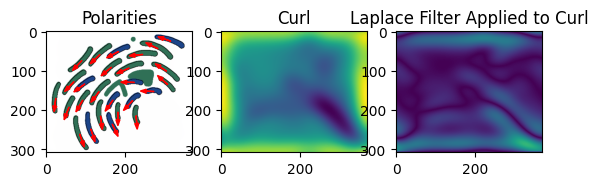

In [56]:
aspect_ratio = sz[1]/sz[0]
coordinates_x = np.ones([sz[0],1]) @ np.array([range(sz[1])])*aspect_ratio/sz[1]
coordinates_y = (np.array([range(sz[0])])/sz[0]).T * np.ones([1,sz[1]])
wavenumbers_1d_x = np.int64(np.array([np.fft.fftfreq(sz[1]) * sz[1]]))
n_fft_points_x = wavenumbers_1d_x.shape[1]
wavenumbers_1d_y = np.int64(np.array([np.fft.fftfreq(sz[0]) * sz[0]]))
n_fft_points_y = wavenumbers_1d_y.shape[1]
wavenumbers_x = np.ones([n_fft_points_y,1]) @ wavenumbers_1d_x
wavenumbers_y = wavenumbers_1d_y.T @ np.ones([1,n_fft_points_x])
w_x_w_y = wavenumbers_x*wavenumbers_x+wavenumbers_y*wavenumbers_y
k = 0.1
flter = np.exp(-k*w_x_w_y)

def get_U_V(polarity):
    U = np.zeros(sz)
    V = np.zeros(sz)
    # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
    for i in range(numbrush):
        V += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])
        U += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]
    U_fft = np.fft.fft2(U)
    V_fft = np.fft.fft2(V)
    U_fft *= flter
    V_fft *= flter
    U = np.fft.ifft2(U_fft, sz)
    V = np.fft.ifft2(V_fft, sz)
    return(U,V)

def curl_fft(polarity):
    U = np.zeros(sz)
    V = np.zeros(sz)
    # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
    for i in range(numbrush):
        V += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])
        U += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]
    
    return curl_fft_UV(U,V)
def curl_fft_UV(U,V):
    d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
    d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
    curl_fft = d_v_d_x_fft - d_u_d_y_fft
    curl_fft *= flter
    return curl_fft
def curl_diagram(curl_fft, best_polarity):
    
    # brush_directions = np.zeros(sz)
    # best_polarity = np.sign(np.mean(opts, axis = 0))
    # plt.subplot(1,2,1)
    # plt.imshow(im)
    im_show = im.copy()
    border_mask = np.zeros(sz)
    plt.subplot(1,3,1)
    # plt.imshow(im)

    for i in range(numbrush):
        # brush_directions += cv2.erode(brushstrokes_dilated[i], np.ones([2,2]))
        sf = 20
        magnitude = np.sqrt(1+1/gradients[i]/gradients[i])
        a = cv2.erode(brushstrokes[i],np.array([[1,1,1],[1,1,1],[1,1,1]]))
        b = brushstrokes[i]-a
        border_mask += b
        plt.arrow(vector_of_xmeans[0,i], vector_of_ymeans[0,i], sf/magnitude/gradients[i]*best_polarity[i], sf/magnitude*best_polarity[i], head_width = 10, color = 'r')
    im_show[np.bool8(border_mask),:] = 0

    im_show_1 = im_show.copy()
    im_show_1 = cv2.cvtColor(im_show_1, cv2.COLOR_BGR2RGB)
    plt.imshow(im_show_1)


    # print(curl_fft.shape)
    curl = np.fft.ifft2(curl_fft, sz)
    curl = np.real(curl)
    plt.title("Polarities")
    plt.subplot(1,3,2)
    plt.imshow(curl)
    plt.title("Curl")
    plt.subplot(1,3,3)
    plt.imshow(np.abs(cv2.filter2D(curl, -1, np.array([[1,2,1],[0,0,0],[-1,-2,-1]]))), vmin=0,vmax = 0.6)
    plt.title("Laplace Filter Applied to Curl")
    # plt.colorbar()
    #Set vmin and vma
rnd = np.sign(np.random.rand(numbrush)-0.5)
curl_diagram(curl_fft(polarity_option), polarity_option)

print(gradients)

# Attempt 2 - Using Vorticity

So far the brushstroke allocation has no measure for how successful the application is based on the resulting flow. We could easily create a function which measures the resulting vorticity. Comparing the random brushstroke allocation to the improved one, we see that the better vorticity pattern has a higher total power since less of it is carried in the high frequency domain which gets blurred.

In [ ]:
#Function to tell us the total power captured by a vortex field.
def total_power(curl_fft):
    PSD = curl_fft*np.conj(curl_fft)
    return (np.real(np.sum(PSD)), PSD)

In [ ]:
#Test the theory - is the total power of the vortex field above higher than that of the random distribution?
U_random = np.zeros(sz)
V_random = np.zeros(sz)
# best_polarity = np.sign(np.random.rand(numbrush)-0.5)
for i in range(numbrush):
    random_polarity = np.sign(random.random()-0.5)
    V_random += brushstrokes_dilated[i]*random_polarity/np.sqrt(1+1/gradients[i]/gradients[i])
    U_random += brushstrokes_dilated[i]*random_polarity/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]

d_u_d_y_fft_random = 1j * wavenumbers_y * np.fft.fft2(U_random)
d_v_d_x_fft_random = 1j * wavenumbers_x * np.fft.fft2(V_random)
curl_fft_random = d_v_d_x_fft_random - d_u_d_y_fft_random
curl_fft_random *= flter

total_power_assigned = total_power(curl_fft(best_polarity))[0]
total_power_random = total_power(curl_fft_random)[0]
print("Assigned", total_power_assigned)
print("Random", total_power_random)
print("Ratio (Assigned/Random)",total_power_assigned/total_power_random)

Assigned 4617081310.339657
Random 7106887614.368554
Ratio (Assigned/Random) 0.649662913059852


In [ ]:
def vorticity_polarity_options():
    opts = np.zeros([num_polarity_options, numbrush])
    for i in range(num_polarity_options):
        opt_valid = False
        while opt_valid == False:
            opt = get_polarity_option()
            opt_valid = opt[0]
            opt = opt[1]
        if (i!=0):
            running_best = np.mean(opts, axis=0)
            diff_pos = running_best - opt
            diff_neg = running_best + opt
            if (np.abs(np.sum(diff_neg)) < np.abs(np.sum(diff_pos))):
                opt *= -1
        opts[i,:] = opt
    powers = np.zeros([num_polarity_options])
    for i in range(num_polarity_options):
        U = np.zeros(sz)
        V = np.zeros(sz)
        # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
        for j in range(numbrush):
            V += brushstrokes_dilated[j]*opts[i,j]/np.sqrt(1+1/gradients[j]/gradients[j])
            U += brushstrokes_dilated[j]*opts[i,j]/np.sqrt(1+1/gradients[j]/gradients[j])/gradients[j]

        d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
        d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
        curl_fft = d_v_d_x_fft - d_u_d_y_fft
        curl_fft *= flter
        powers[i] = total_power(curl_fft)[0]
    return (opts,powers)

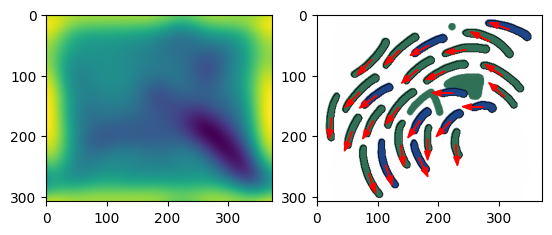

In [ ]:
opts_powers = vorticity_polarity_options()
best_polarity_vorticity = np.sign(np.sum(opts_powers[0]*np.array([opts_powers[1]]).T/np.sum(opts_powers[1]),axis=0))
curl_diagram(curl_fft(best_polarity_vorticity))

In [ ]:
# with open('../out/polarities.pkl', 'wb') as outp:
#     pickle.dump(best_polarity_vorticity, outp, pickle.HIGHEST_PROTOCOL)
# U_V = get_U_V(best_polarity_vorticity)
# with open('../out/U.pkl', 'wb') as outp:
#     pickle.dump(U_V[0], outp, pickle.HIGHEST_PROTOCOL)
# with open('../out/V.pkl', 'wb') as outp:
#     pickle.dump(U_V[1], outp, pickle.HIGHEST_PROTOCOL)

# Active Methods

# Validation Methods
These are all the methods we use to validate the methodology identified above

In [16]:
def validate_polarities(numval):
    
    for i in range(numval):
        with open('../out/validation'+'{:03}'.format(i)+'/seeds.pkl', 'rb') as inp:
            seeds = pickle.load(inp)
        # print(seeds[:,0].shape)
        with open('../out/validation'+'{:03}'.format(i)+'/gradients.pkl', 'rb') as inp:
            gradients = pickle.load(inp)
        # gradients = -1*np.reciprocal(gradients)
        with open('../out/validation'+'{:03}'.format(i)+'/polarities.pkl', 'rb') as inp:
            polarities = pickle.load(inp)
        option = get_polarity_option(seeds, gradients)
        diff = option - polarities
        diff_2 = option + polarities
        if (np.abs(np.sum(diff*diff)) > np.abs(np.sum(diff_2*diff_2))):
            option = -option
        diff = (option - polarities)/2
        # print(diff)
        numbrush = np.shape(seeds)[0]
        print("Validation", i, "Error", np.sum(diff*diff)/numbrush)
        for i in range(numbrush):
            arrowmag = np.sqrt(1+1/gradients[i]/gradients[i])/10
            col = 'b'
            if (diff[i] != 0):
                col = 'r'
            # plt.plot(seeds[i,0],seeds[i,1], 'b*')
            plt.arrow(seeds[i,0], seeds[i,1], option[i] * 1/gradients[i]/arrowmag, option[i] * 1/arrowmag, head_width = 0, head_length = 0, color = col)
        plt.show()


        

Validation 0 Error 0.2734375


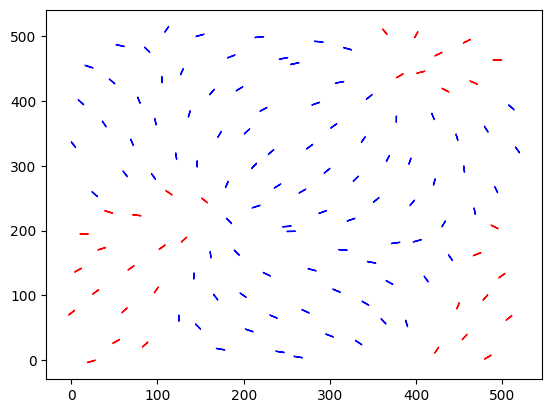

Validation 1 Error 0.4609375


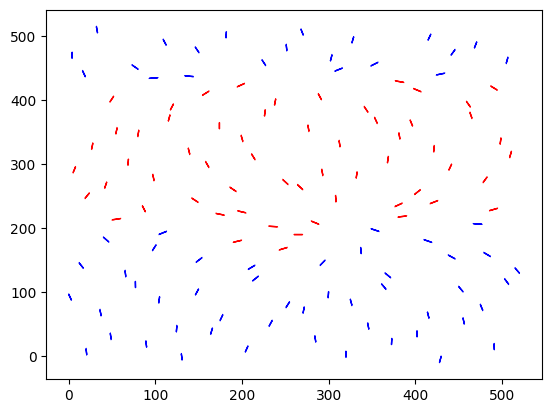

Validation 2 Error 0.3828125


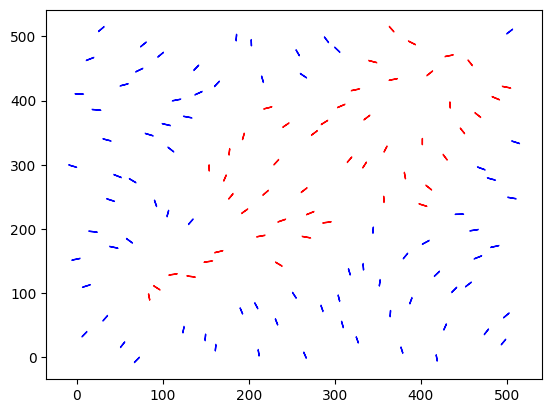

Validation 3 Error 0.4609375


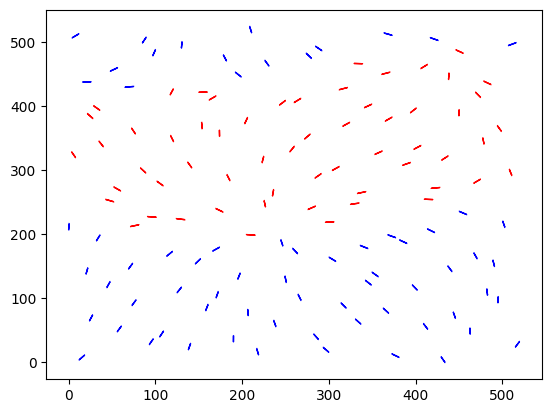

Validation 4 Error 0.4296875


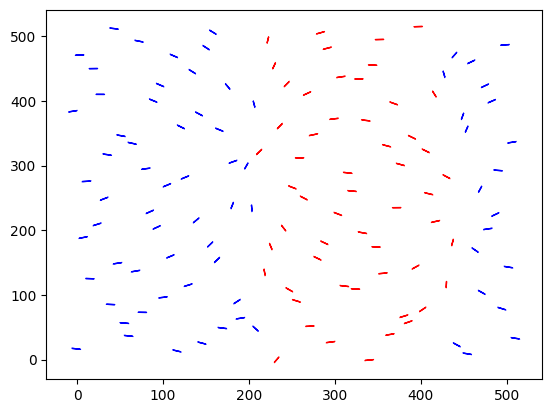

Validation 5 Error 0.3984375


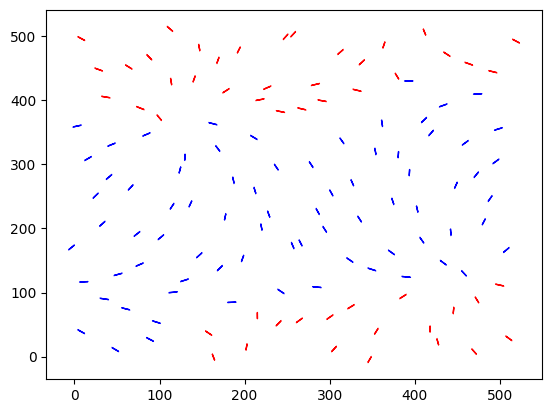

Validation 6 Error 0.4296875


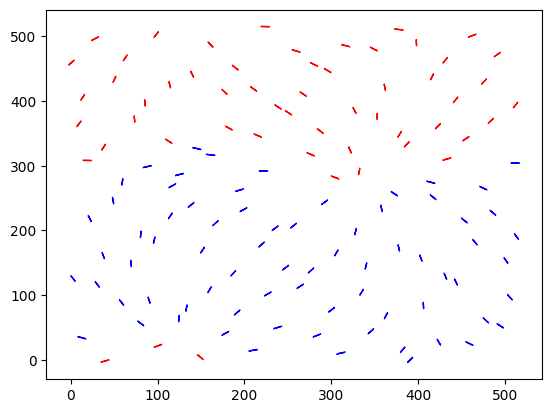

Validation 7 Error 0.4609375


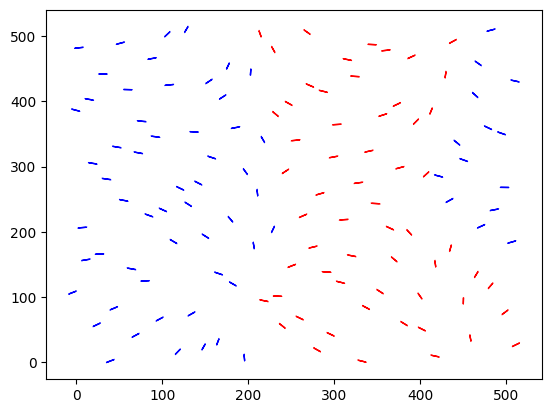

Validation 8 Error 0.46875


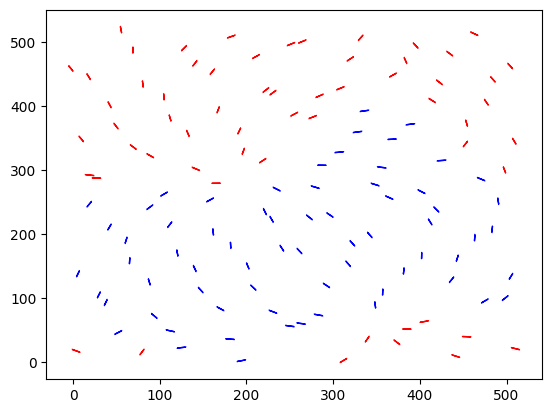

Validation 9 Error 0.46875


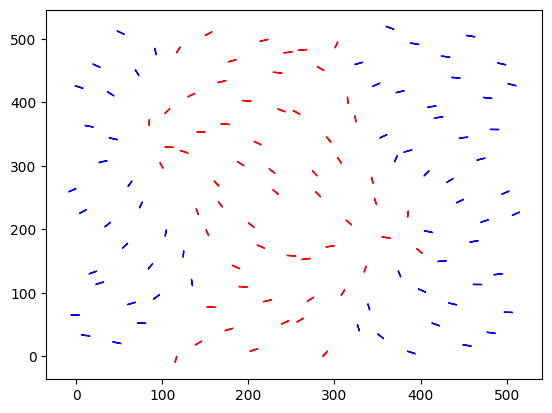

In [17]:
validate_polarities(10)